미세먼지(PM10) 예측 예제

In [7]:
#필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#폰트지정
plt.rcParams["font.family"]="Malgun Gothic";

#마이너스 부호 깨짐 지정
plt.rcParams["axes.unicode_minus"]=False;

#숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format="{:.2f}".format;

#데이터 로드
file_path="dataset/seoul_pm10.csv";
df=pd.read_csv(file_path,encoding="cp949");

print("데이터 크기:",df.shape);
print("\n처음 5개 행:")
display(df.head());

#기본 데이터 정보 확인
print("\n데이터 기간:",df["date"].min(),"~",df["date"].max());
print("총 관측 수:",len(df));
print("지역 수",df["area"].nunique);
print("\n결측치 개수:")
display(df.isnull().sum());

데이터 크기: (227759, 4)

처음 5개 행:


,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.00,44.00
1,2022-12-31 23:00,강동구,68.00,55.00
2,2022-12-31 23:00,강북구,59.00,42.00
3,2022-12-31 23:00,강서구,62.00,40.00
4,2022-12-31 23:00,관악구,57.00,38.00



데이터 기간: 2022-01-01 0:00 ~ 2022-12-31 9:00
총 관측 수: 227759
지역 수 <bound method IndexOpsMixin.nunique of 0         강남구
1         강동구
2         강북구
3         강서구
4         관악구
         ... 
227754    용산구
227755    은평구
227756    종로구
227757     중구
227758    중랑구
Name: area, Length: 227759, dtype: object>

결측치 개수:


date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64

#데이터 전처리

In [11]:

#날짜 변환
df["date"]=pd.to_datetime(df["date"]);
#결측치 처리
df["pm10"]=df["pm10"].fillna(df["pm10"].mean());
df["pm2.5"]=df["pm2.5"].fillna(df["pm2.5"].mean());

#시간관련 피처 추가
df["hour"]=df["date"].dt.hour;
df["day_of_week"]=df["date"].dt.dayofweek;
df["month"]=df["date"].dt.month;

#지역 원-핫 인코딩
df_encoded=pd.get_dummies(df,columns=["area"],prefix="area");

#전처리된 데이터 확인
print("\n전처리된 데이터 샘플:");
display(df_encoded.head());


전처리된 데이터 샘플:


,date,pm10,pm2.5,hour,day_of_week,month,area_강남구,area_강동구,area_강북구,area_강서구,area_관악구,area_광진구,area_구로구,area_금천구,area_노원구,area_도봉구,area_동대문구,area_동작구,area_마포구,area_서대문구,area_서초구,area_성동구,area_성북구,area_송파구,area_양천구,area_영등포구,area_용산구,area_은평구,area_종로구,area_중구,area_중랑구,area_평균
0,2022-12-31 23:00:00,57.00,44.00,23,5,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2022-12-31 23:00:00,68.00,55.00,23,5,12,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2022-12-31 23:00:00,59.00,42.00,23,5,12,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2022-12-31 23:00:00,62.00,40.00,23,5,12,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2022-12-31 23:00:00,57.00,38.00,23,5,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


모델학습

In [17]:
#pm10 모델학습
features_pm10=["pm2.5","hour","day_of_week","month"]+[col for col in df_encoded.columns if col.startswith("area_")];
X_pm10=df_encoded[features_pm10];
y_pm10=df_encoded["pm10"];

#pm2.5 모델학습
features_pm25=["pm10","hour","day_of_week","month"]+[col for col in df_encoded.columns if col.startswith("area_")];
X_pm25=df_encoded[features_pm25];
y_pm25=df_encoded["pm2.5"];

#데이터 분할
X_train_pm10,X_test_pm10,y_train_pm10,y_test_pm10=train_test_split(X_pm10,y_pm10,test_size=0.2,random_state=42);
X_train_pm25,X_test_pm25,y_train_pm25,y_test_pm25=train_test_split(X_pm25,y_pm25,test_size=0.2,random_state=42);

#모델학습
model_pm10=LinearRegression();
model_pm25=LinearRegression();

model_pm10.fit(X_train_pm10,y_train_pm10);
model_pm25.fit(X_train_pm25,y_train_pm25);

#모델 평가

In [19]:
y_pred_pm10=model_pm10.predict(X_test_pm10);
y_pred_pm25=model_pm25.predict(X_test_pm25);

print("\nPM10 모델 성능");
print(f"R2 Score: {r2_score(y_test_pm10,y_pred_pm10):.4f}");
print(f"MSE: {mean_squared_error(y_test_pm10,y_pred_pm10):.4f}");




PM10 모델 성능
R2 Score: 0.6079
MSE: 198.3575



예측가능한 지역:


['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구',
 '평균']


선택된 지역: 강남구


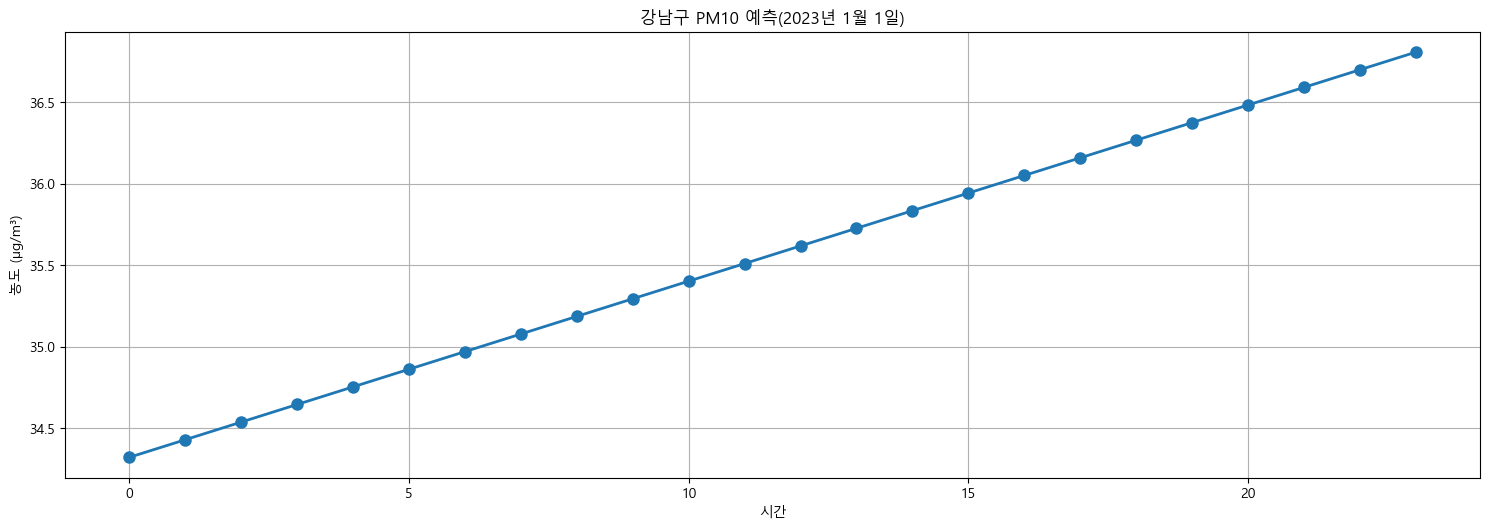

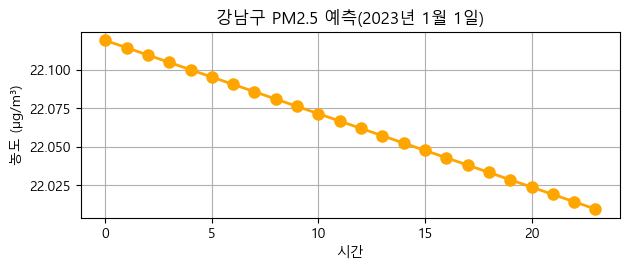

In [24]:
#2023년 1월 1일 예측을 위한 함수
def create_prediction_data(area):
    predictions=[];
    for hour in range(24):
        pred_data={
            "hour":hour,
            "day_of_week":6,    #2023년 1월 1일은 일요일
            "month":1
        }
        
        #지역 원-핫 인코딩 추가
        for area_col in [col for col in df_encoded.columns if col.startswith("area_")]:
            pred_data[area_col]=1 if area_col==f"area_{area}" else 0
        predictions.append(pred_data);
    return pd.DataFrame(predictions);

#사용자 입력-지역선택
areas=sorted(df["area"].unique());
print("\n예측가능한 지역:");
display(areas);

#예시로 한 지역 선택(실제로는 사용자가 선택)
selected_area=areas[0];
print(f"\n선택된 지역: {selected_area}");

#2023년 1월 1일 예측
future_data=create_prediction_data(selected_area);
pm10_predictions=[];
pm25_predictions=[];

#반복예측 (PM10과 PM2.5 상호 의존성 처리)
for hour in range(24):
    hour_data=future_data.iloc[[hour]].copy();
    
    #초기값 설정
    hour_data["pm2.5"]=df["pm2.5"].mean();
    hour_data["pm10"]=df["pm10"].mean();
    
    #반복예측으로 정확도 향상
    for _ in range(3):
        pm10_pred=model_pm10.predict(hour_data[features_pm10]);
        pm25_pred=model_pm25.predict(hour_data[features_pm25]);
        
        hour_data["pm10"]=pm10_pred;
        hour_data["pm2.5"]=pm25_pred;
    
    pm10_predictions.append(pm10_pred[0]);
    pm25_predictions.append(pm25_pred[0]);
    
#예측 결과 시각화
plt.figure(figsize=(15,10));

#PM10 그래프
plt.subplot(2,1,1);
plt.plot(range(24),pm10_predictions,marker="o",linewidth=2,markersize=8);
plt.title(f"{selected_area} PM10 예측(2023년 1월 1일)");
plt.xlabel("시간");
plt.ylabel('농도 (μg/m³)');
plt.grid(True);
plt.tight_layout();
plt.show();

#PM2.5 그래프
plt.subplot(2,1,2);
plt.plot(range(24),pm25_predictions,marker="o",linewidth=2, markersize=8,color="orange");
plt.title(f"{selected_area} PM2.5 예측(2023년 1월 1일)");
plt.xlabel("시간");
plt.ylabel('농도 (μg/m³)');
plt.grid(True);
plt.tight_layout();
plt.show();


PM10 예측 통계:
평균: 35.6 μg/m³
최대: 36.8 μg/m³
최소: 34.3 μg/m³

PM2.5 예측 통계:
평균: 22.1 μg/m³
최대: 22.1 μg/m³
최소: 22.0 μg/m³

시간별 예측값:


,시간,PM10,PM2.5
0,0,34.3,22.1
1,1,34.4,22.1
2,2,34.5,22.1
3,3,34.6,22.1
4,4,34.8,22.1
5,5,34.9,22.1
6,6,35.0,22.1
7,7,35.1,22.1
8,8,35.2,22.1
9,9,35.3,22.1


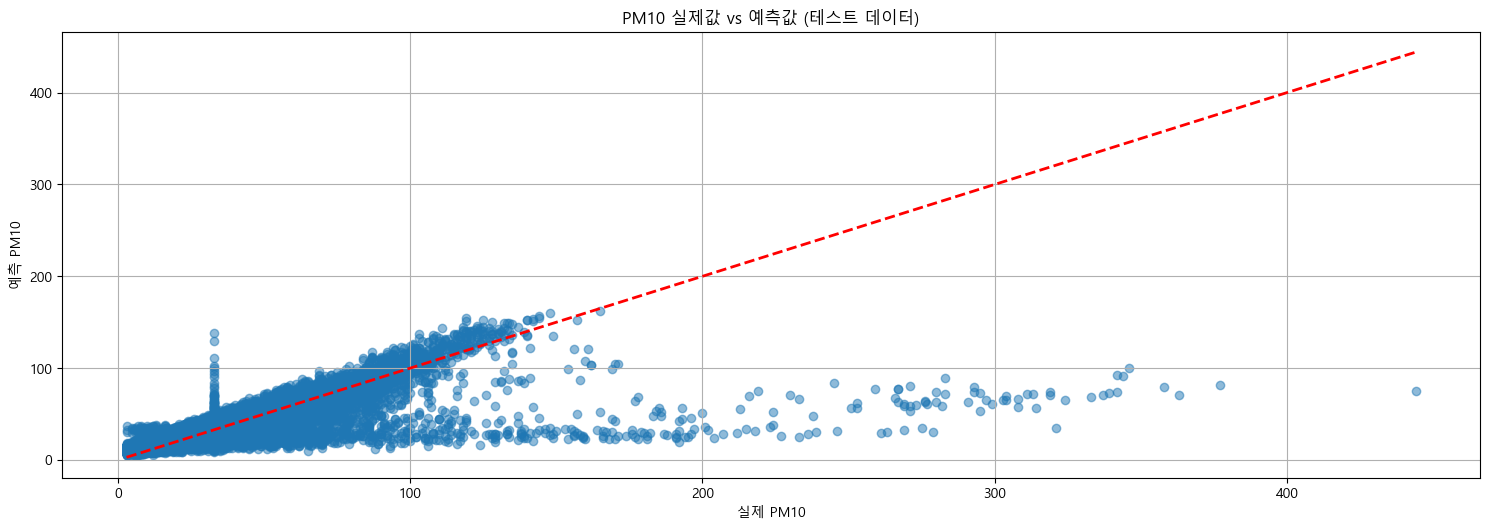

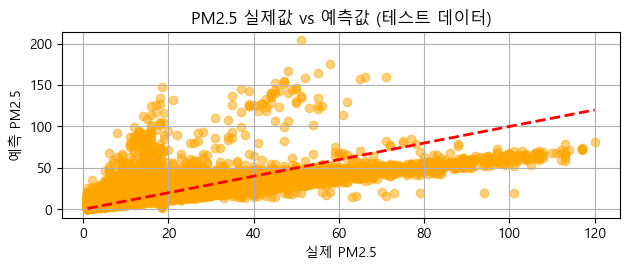

In [26]:
#예측 결과 통계
print("\nPM10 예측 통계:")
print(f"평균: {np.mean(pm10_predictions):.1f} μg/m³")
print(f"최대: {np.max(pm10_predictions):.1f} μg/m³");
print(f"최소: {np.min(pm10_predictions):.1f} μg/m³");

print("\nPM2.5 예측 통계:");
print(f"평균: {np.mean(pm25_predictions):.1f} μg/m³");
print(f"최대: {np.max(pm25_predictions):.1f} μg/m³");
print(f"최소: {np.min(pm25_predictions):.1f} μg/m³");


#시간별 예측값 데이터프레임 생성
hourly_predictions=pd.DataFrame({
    "시간":range(24),
    "PM10":[f"{x:.1f}" for x in pm10_predictions],
    "PM2.5":[f"{x:.1f}" for x in pm25_predictions]
});

print("\n시간별 예측값:");
display(hourly_predictions);

#실제값과 예측값 비교 시각화(테스트 데이터 기준)
plt.figure(figsize=(15,10));

# PM10 비교
plt.subplot(2, 1, 1)
plt.scatter(y_test_pm10, y_pred_pm10, alpha=0.5)
plt.plot([y_test_pm10.min(), y_test_pm10.max()],
         [y_test_pm10.min(), y_test_pm10.max()],
         'r--', lw=2)
plt.xlabel('실제 PM10')
plt.ylabel('예측 PM10')
plt.title('PM10 실제값 vs 예측값 (테스트 데이터)')
plt.grid(True)
plt.tight_layout()
plt.show()

# PM2.5 비교
plt.subplot(2, 1, 2)
plt.scatter(y_test_pm25, y_pred_pm25, alpha=0.5, color='orange')
plt.plot([y_test_pm25.min(), y_test_pm25.max()],
         [y_test_pm25.min(), y_test_pm25.max()],
         'r--', lw=2)
plt.xlabel('실제 PM2.5')
plt.ylabel('예측 PM2.5')
plt.title('PM2.5 실제값 vs 예측값 (테스트 데이터)')
plt.grid(True)
plt.tight_layout()
plt.show()

직원 퇴사예측예제